#### Foreword 

This notebook is a study and replication of StrataScratch’s “Sales Analysis” project, which has been used as a take-home assignment in some data-science hiring processes (e.g., 23andMe).

What you’ll see below follows the original prompts: 
1. trend visualization of daily sales. 
2. identification of a structural change and a statistical significance check.
3. exploration of gender mix versus the change.
4. a daypart breakdown of sales. 

The emphasis is on clarity of thought, reproducibility, and communication—showing how I approach EDA, hypothesis framing, testing, and interpretable reporting rather than chasing a single “right” answer.



In [98]:
# import relevant libraries
import pandas as pd
import numpy as np
import glob

##### Data Ingestion Plan

Read all weekly CSVs via a glob pattern. Parse date columns to datetime during read if available, and confirm consistent schema across weeks.

A quick refresher on what glob does: 
* Finds files by pattern (no manual filenames).
* Patterns use Unix-style wildcards:
    * matches any chars (e.g., data/raw/*.csv)
    * ? matches a single char (e.g., week_?.csv)
    * [abc] or [0-9] matches sets/ranges

In [99]:
# locate the files to read given the location and the file name pattern
file_pattern='../datasets/*.csv'
all_files=glob.glob(file_pattern)

# read all the weekly sales transaction and save them in a list of dataframe
weekly_sales= [pd.read_csv(file) for file in all_files]

##### Sanity checks on ingestion

Report the number of files stored in the list to verify coverage.

In [100]:
# check if the size of list is equal to the number of files in datasets
print("No. of weeks of sales data in the list: {:}".format(len(weekly_sales)))

No. of weeks of sales data in the list: 50


Check to see the format and the columns of the datasets in the list

In [101]:
# perform sanity check
#for i, week in enumerate(weekly_sales, start=1):
    #print("\nWeek {:} \n{:}".format(i, week.head(-5)))

# dataset is formatted as expected, two columns named sale_time and purchaser_gender comprise the datasets

It looks like the files are not being read in a chronological order so as a workaround we combine the weekly sales to one single dataframe and sort based on the sale_time column.

In [102]:
# combine the weekly dataframes as one single dataframe to sales
combined_sales_data=pd.concat(weekly_sales, ignore_index=True)

# convert the sale_time column to datetime format if not already
combined_sales_data['sale_time']=pd.to_datetime(combined_sales_data['sale_time'])

# check the dataset to see if the above methods were correctly executed
combined_sales_data.head()

# check the data types of the columns
for col in combined_sales_data.columns:
    print("{:} : {:}".format(col, combined_sales_data[col].dtype))

# check the dataframe 
combined_sales_data.head()

# sort the dataframe according to the sale_time column
combined_sales_data.sort_values(by='sale_time', inplace=True)


# reset the indexes of the transactions in the dataframe and check the dataframe again
combined_sales_data.reset_index(drop=True, inplace=True)
combined_sales_data.head(-5)
print("Number of rows in the dataset: "+str(len(combined_sales_data)))

# load the statistics of the columns
combined_sales_data.describe(include='all')

sale_time : datetime64[ns]
purchaser_gender : object
Number of rows in the dataset: 204329


,sale_time,purchaser_gender
count,204329,204329
unique,NaN,2
top,NaN,female
freq,NaN,107740
mean,2013-04-08 10:37:50.271200,NaN
min,2012-10-01 01:42:22,NaN
25%,2013-01-10 13:55:27,NaN
50%,2013-04-21 11:30:57,NaN
75%,2013-07-05 13:07:39,NaN
max,2013-09-15 23:48:47,NaN


Now since this combined dataframe is sorted, we split this database per each week to get a list of weekly sales. The elements of the list would now be sorted in chronological order.

In [103]:
# set the sale_time column as the index so that pd.Grouper can use it for grouping
combined_sales_data.set_index('sale_time', inplace=True)

# group the data by week using pd.Grouper. By default, 'W' groups weeks ending on Sunday.
weekly_groups = combined_sales_data.groupby(pd.Grouper(freq='W'))

# create a list of weekly DataFrames by iterating over the groups
weekly_sales_final = [group.reset_index() for _, group in weekly_groups]



In [104]:
#check to see if the weekly sales data is properly loaded

# perform sanity checks
total_row_count=0
for i, week in enumerate(weekly_sales_final,start=1):
    total_row_count+=week.sale_time.count()


print("\nTotal number of rows in all the weekly sales: {:}".format(total_row_count))


Total number of rows in all the weekly sales: 204329


Now we create a dataframe where the columns are the week number, the number of transactions for that week, the number of male and female customers

In [105]:
# create an empty list to store each week's summary statistics
weekly_stats = []

# loop over the list of weekly DataFrames using enumerate to track week numbers (starting at 1)
for i, week_df in enumerate(weekly_sales_final, start=1):
    # count the total number of transactions in the current week
    num_transactions = week_df.shape[0]
    
    # count the number of transactions where purchaser_gender is 'male'
    num_males = (week_df['purchaser_gender'].str.lower() == 'male').sum()
    
    # count the number of transactions where purchaser_gender is 'female'
    num_females = (week_df['purchaser_gender'].str.lower() == 'female').sum()
    
    # append a dictionary with the week's statistics to the weekly_stats list
    weekly_stats.append({
        'week_no': i,
        'num_transactions': num_transactions,
        'num_male_transactions': num_males,
        'num_female_transactions': num_females
    })

# create a new DataFrame from the list of weekly statistics
weekly_summary_df = pd.DataFrame(weekly_stats)
print(weekly_summary_df.shape)

(50, 4)


We plot the weekly sales data to see the trend of the sales

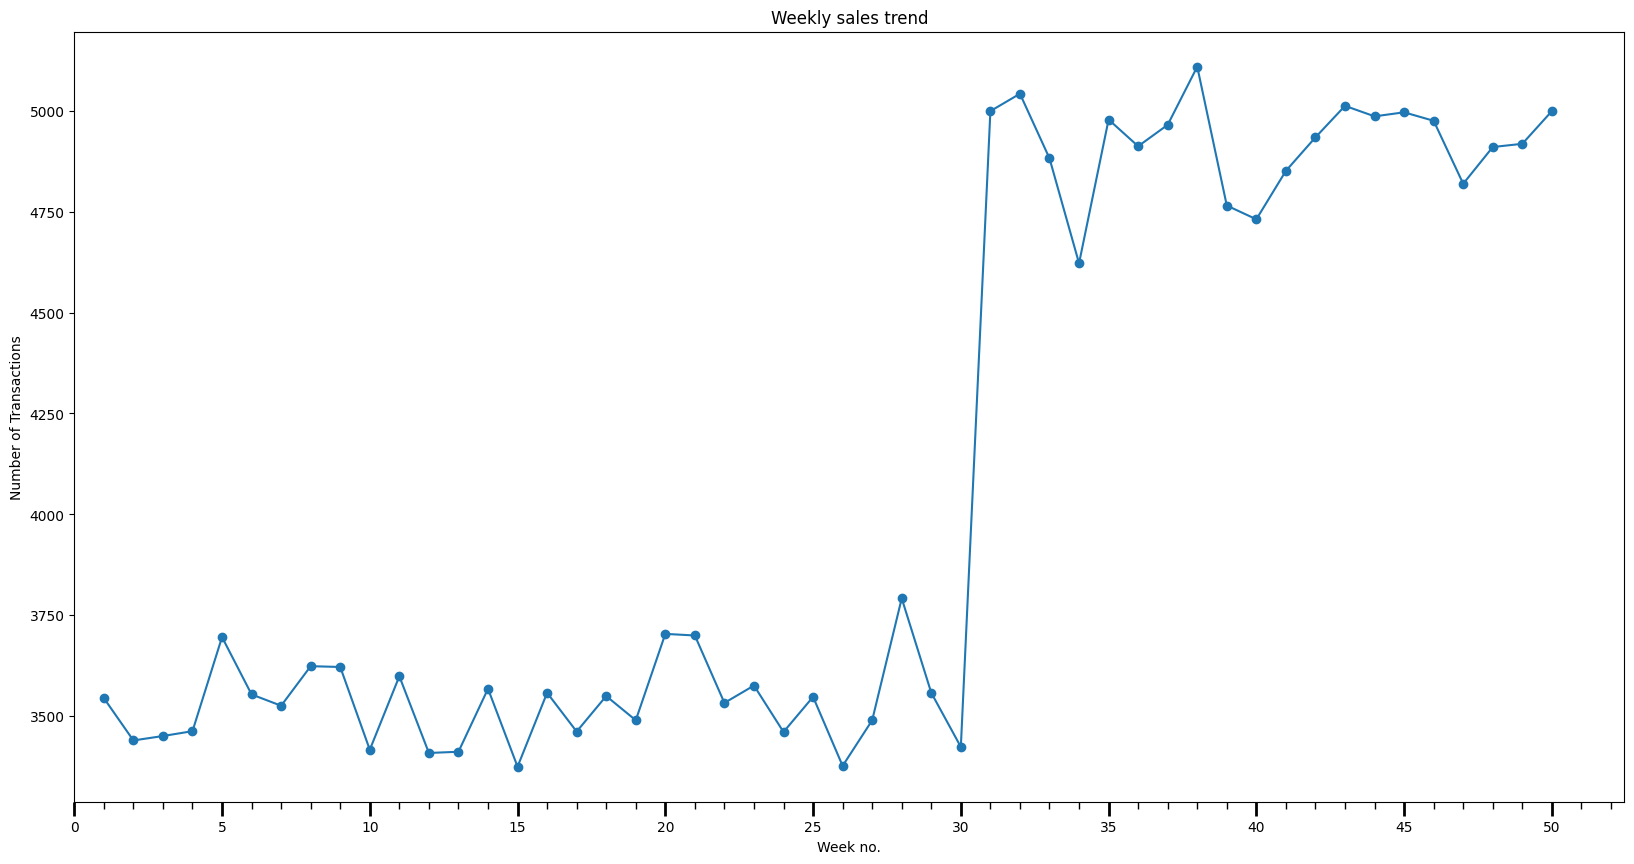

In [106]:
# import relevant functions and modules
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# plot the line plot
plt.figure(figsize=(20,10))
plt.plot(weekly_summary_df['week_no'], weekly_summary_df['num_transactions'], marker='o', linestyle='-')
plt.xlabel('Week no.')
plt.ylabel('Number of Transactions')
plt.title("Weekly sales trend")

# format the ticks on x-axis
ax=plt.gca() #get current axis instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(5)) #set the biggger ticks to be 5 units apart
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1)) #set the samller ticks to be 1 unit apart

# customize only x-axis major ticks
ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=10)

# customize only x-axis minor ticks
ax.tick_params(axis='x', which='minor', length=5, width=1, labelsize=8)
ax.set_xlim(left=0)

plt.show()

Now, we want to group the daily transaction data based on the days and see exactly what date the change in sales occured.

In [107]:
# ensure the index sale_time is set as a column for the purposes of grouping
combined_sales_data.reset_index(inplace=True)

# create a new column to group the dataframe just by the date of the transaction
combined_sales_data['sale_date'] = combined_sales_data['sale_time'].dt.date

# create a dataframe with columns sale_date, num_transactions, female_customers and male_customers
daily_sale_stats = combined_sales_data.groupby('sale_date').agg(num_transactions=('purchaser_gender', 'count'), female_customers=('purchaser_gender', lambda x: (x=='female').sum()), male_customers=('purchaser_gender', lambda x: (x=='male').sum())).reset_index()


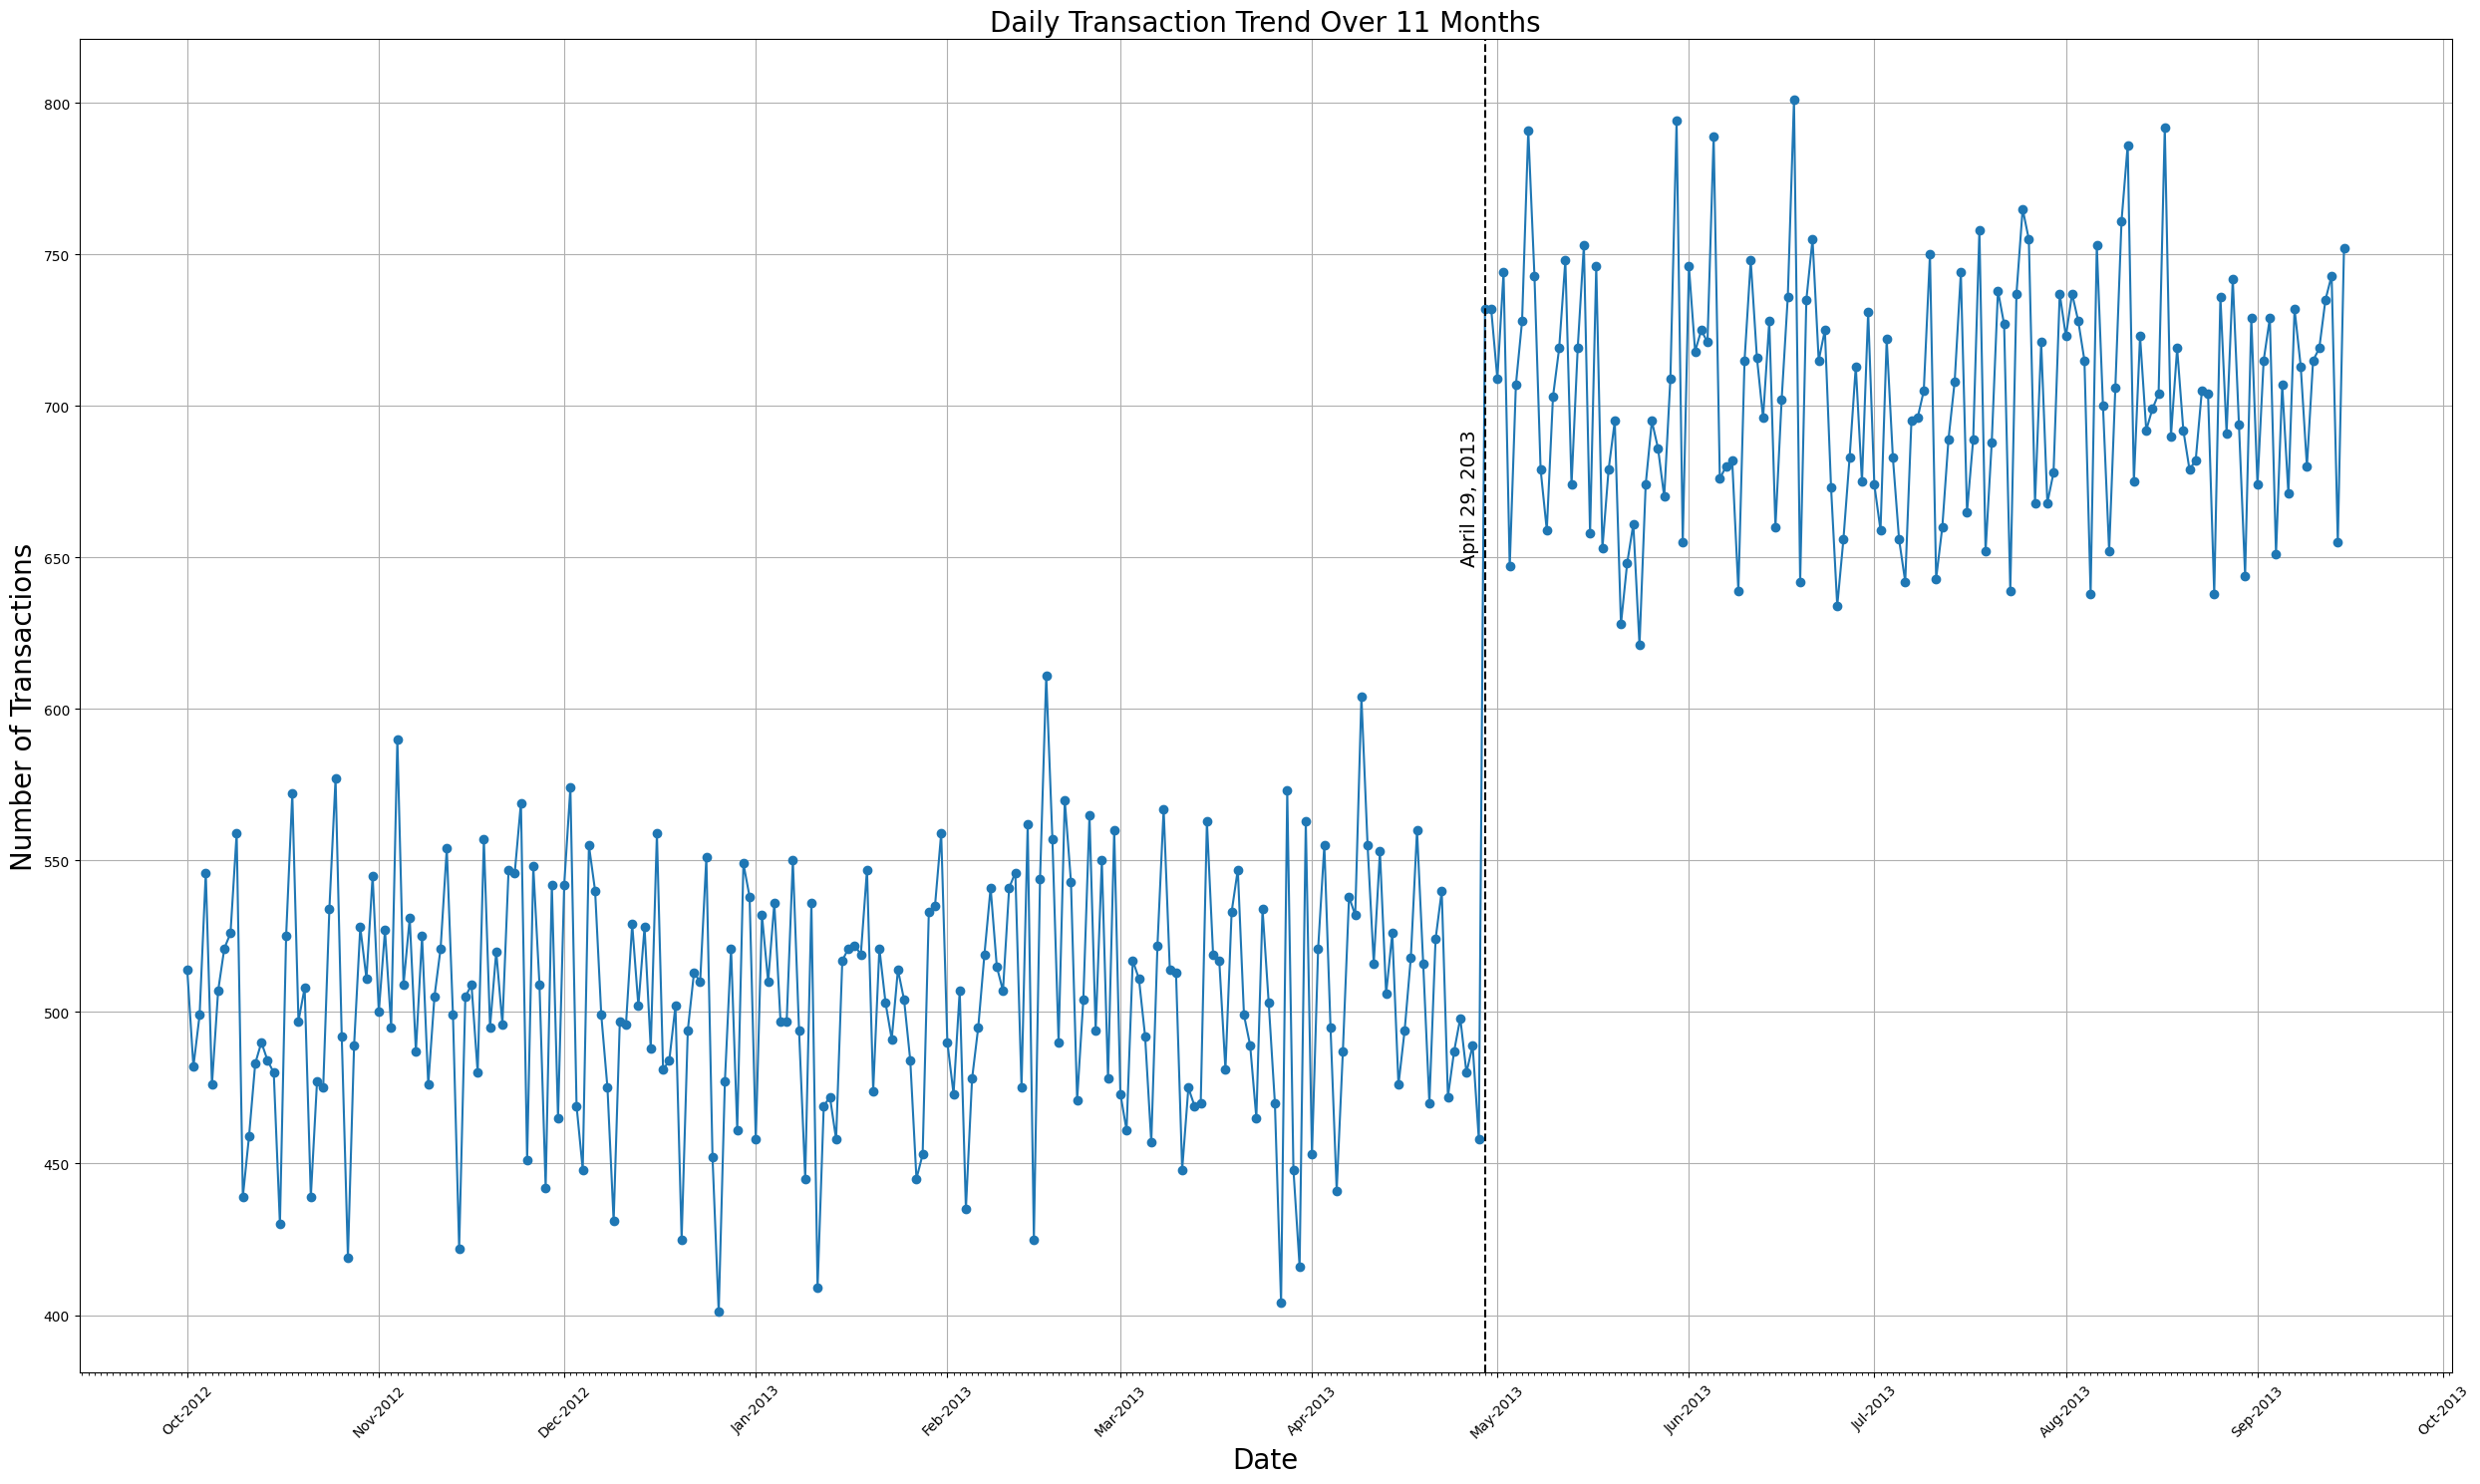

In [108]:
# plot the lineplot for the number of transactions in each day to see the trend
import matplotlib.dates as mdates # type: ignore

plt.figure(figsize=(25, 15))
plt.plot(daily_sale_stats['sale_date'], daily_sale_stats['num_transactions'], marker='o', linestyle='-')

# get the current axes instance
ax = plt.gca()

# set major ticks on each new month and format to look clean
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# optionally, set minor ticks (for more granular control)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

# label the axis, plot and format for cleaner look
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Transactions', fontsize=20)
plt.title('Daily Transaction Trend Over 11 Months', fontsize=20)
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# place a vertical line and a text on the day of the trend change
trend_change_date = pd.to_datetime("2013-04-29")
offset = pd.Timedelta(days=4) # offset to align the text to the left of the line
new_x = trend_change_date - offset # plot point where the text should go
plt.axvline(trend_change_date, color='black', linestyle='--')
plt.text(new_x, plt.ylim()[1]*0.79, 'April 29, 2013', color='black', rotation=90, fontsize=14)
plt.show()

We have proven visually the biggest change in daily transaction was on April 29, 2013. Now we do this methodically using Pandas. In doing it, we form a new column which computes the absolute value of the change in transactions from a given day to the previous day. This will be important for our statistical analysis in determining if the change in daily transactions happened due to normal chance or not.

In [109]:
# create a new column change_in_daily_transaction which computes how today's transaction compares to yesterday's
daily_sale_stats['change_in_daily_transactions'] = daily_sale_stats['num_transactions'].diff().abs()

# get the index of the row corresponding to the highest change in transaction number
highest_change_index = daily_sale_stats['change_in_daily_transactions'].idxmax()

# display the row with the highest change
daily_sale_stats.iloc[highest_change_index]

sale_date                       2013-04-29
num_transactions                       732
female_customers                       383
male_customers                         349
change_in_daily_transactions         274.0
Name: 210, dtype: object

We now have all the information needed to tackle if the change in daily transaction was purely by change or if it was statistically significant. First, we start by separating the datasets as before and after (inclusive of the spike) the change in daily transactions.

In [110]:
# convert the column 'sale_date' into a datetime64[ns] type 
daily_sale_stats['sale_date'] = pd.to_datetime(daily_sale_stats['sale_date'], errors='raise')
# define the date at which the larhest cange in daily sales occurred
change_date = pd.Timestamp('2013-04-29')

# split the dataset into two groups: one before the change date and one after (inclusive)
# since the dataframe index contains datetime values, direct comparison is valid

before = daily_sale_stats[daily_sale_stats.sale_date < change_date]['num_transactions']
after = daily_sale_stats[daily_sale_stats.sale_date >= change_date]['num_transactions']

#### **Hypothesis test: Pre vs Post Daily Transactions**

We test whether the mean daily transactions shifted after the candidate change date (2013-04-29).

##### **Hypotheses**
* H₀ (null): the two samples (pre and post) come from populations with the same mean daily transactions (μ₁ = μ₂).
* H₁ (alt): the mean daily transactions differ between the two periods (μ₁ ≠ μ₂). For a one-sided test, we would specify μpost > μpre.

##### **Test used**
Welch’s two-sample t-test (scipy.stats.ttest_ind with equal_var=False). This version does not assume equal variances or equal sample sizes.

##### **Assumptions**

* The two groups are independent (no overlap in days).
* Observations within each group are independent.
* Each group’s daily transaction counts are approximately normally distributed, or the sample sizes are large enough for the Central Limit   Theorem to apply.
* Welch’s test allows unequal variances between groups.



In [111]:
from scipy import stats

t_stat, p_val = stats.ttest_ind(before, after, equal_var = False)
print('t-statistic: ', t_stat)
print('p-value: ', p_val)

t-statistic:  -45.943533193935615
p-value:  3.487246853115062e-138


The obtained p-value as the result of the two-sample t-test is 3.48e-138, which is considerably lower than the conventional threshold of 0.05. This extremely small p-value provides string statistical evidence that the difference in daily sales before and after the chage date is not due to random chance. Therefore, we can confidently conclude that this particular date marks a statistically significant shift in sales behavior.

Next, we investigate if the change in proportion of customer based on gender was the reason for this spike. 

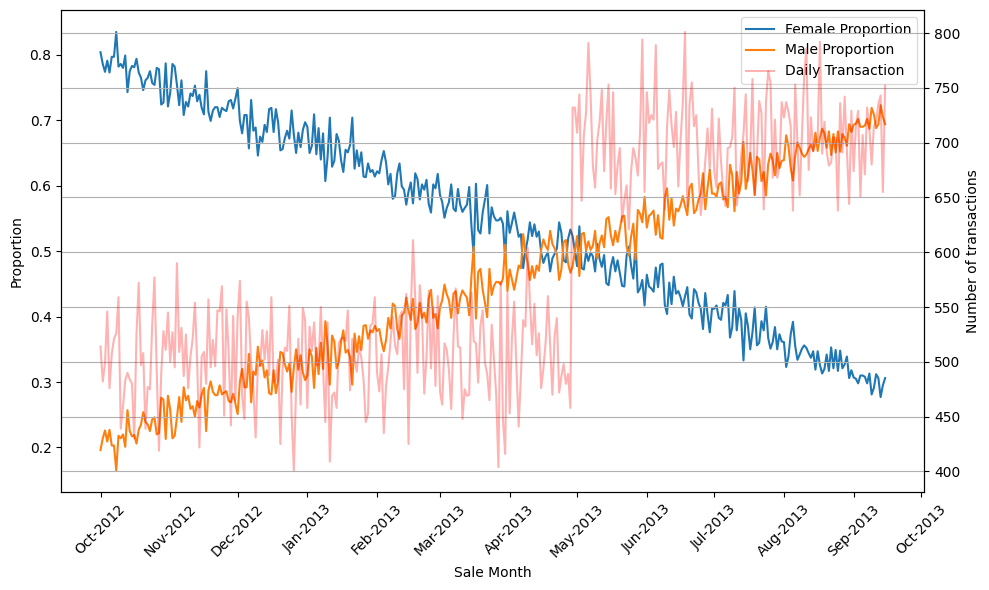

In [112]:
# create a new column in daily_sale_stats named fem_prop and male_prop
daily_sale_stats['fem_prop'] = round(daily_sale_stats['female_customers'] / (daily_sale_stats['female_customers'] + daily_sale_stats['male_customers']),3)
daily_sale_stats['male_prop'] = round(daily_sale_stats['male_customers'] / (daily_sale_stats['male_customers'] + daily_sale_stats['female_customers']),3)

# check the updated dataframe
daily_sale_stats.head(-5)

# create a line plot of the  proportion of male vs female sale transactions
plt.figure(figsize=(10,6))
plt.plot(daily_sale_stats['sale_date'], daily_sale_stats['fem_prop'], linestyle='-', label='Female Proportion')
plt.plot(daily_sale_stats['sale_date'], daily_sale_stats['male_prop'], linestyle='-', label='Male Proportion')

# refine the axis space to look cleaner
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Sale Month')
ax.set_ylabel("Proportion")

# create a overlay of the daily sales transactions in the same figure
ax2 = ax.twinx()
ax2.plot(daily_sale_stats['sale_date'], daily_sale_stats['num_transactions'], linestyle='-', color='red', label='Daily Transaction', alpha=0.3)
ax2.set_ylabel("Number of transactions")

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', framealpha=0.7)

plt.grid(True)
plt.tight_layout()
plt.show()

While the male customer proportion steadily increased through the months, the female customer proportion declined at almost the same rate. So the change in more male customers is not enough to justify the sales increase from the start of May 2013. There might be some other factor(s) that may have caused the change in number of daily transactions.

We now want to understand the sales amount distribution over different times in a day. We start by categorizing the time periods of the days in four different categories, we want to see what the distribution of transaction for each period looks like.

In [113]:
# define a function that takes the time as input and assigns a period to it
def time_period_assigner(time):
    if time >=6 and time<12:
        return 'morning'
    elif time >=12 and time<18:
        return 'afternoon'
    elif time>=18 and time<24: 
        return 'evening'
    else: 
        return 'night'

In [114]:
# define a new column in combined_sales_data to include the sale_time_hour
combined_sales_data['sale_time_hour'] = combined_sales_data['sale_time'].dt.ceil('h').dt.hour #ceiling applied to account for the minutes passed for edge cases
#print(combined_sales_data['sale_time_hour'])

# create a new column called sale_period that categorizes the sales time
combined_sales_data['sale_period'] = combined_sales_data['sale_time_hour'].transform(time_period_assigner)

# find the proportion of sale for each period
prop_df = combined_sales_data.sale_period.value_counts().reset_index()
prop_df['proportion'] = prop_df['count'] / prop_df['count'].sum()

#check the proportion dataframe
prop_df

,sale_period,count,proportion
0,afternoon,81159,0.397198
1,morning,56080,0.274459
2,evening,53523,0.261945
3,night,13567,0.066398


In [115]:
# the above method does not account for edge cases like 23:45 and would convert it to 24
# 23:45 should be characterized as evening, but ends up being characterized as night

# Alternatively we use the groupby and pd.Grouper for more accurate distinctions instead of using the ceiling function
test_df=combined_sales_data.groupby(pd.Grouper(key='sale_time', freq='6h', origin='start_day', closed='left', label='left')).agg(total_sales=('sale_time', 'count')).reset_index()
test_df

,sale_time,total_sales
0,2012-10-01 00:00:00,44
1,2012-10-01 06:00:00,155
2,2012-10-01 12:00:00,202
3,2012-10-01 18:00:00,113
4,2012-10-02 00:00:00,46
...,...,...
1395,2013-09-14 18:00:00,124
1396,2013-09-15 00:00:00,64
1397,2013-09-15 06:00:00,226
1398,2013-09-15 12:00:00,307


In [116]:
# create a custom function to assign period according to the time period
def period_assign(time):
    if time == 0:
        return 'night'
    elif time == 6: 
        return 'morning'
    elif time == 12:
        return 'afternoon'
    else: 
        return 'evening'

In [117]:
test_df['sale_hour'] = test_df['sale_time'].dt.hour
test_df['sale_period'] = test_df['sale_hour'].transform(period_assign)
test_df.drop(columns=['sale_hour', 'sale_time'], inplace=True)


In [118]:
test_df.groupby('sale_period')['total_sales'].sum().reset_index().sort_values('total_sales', ascending=False)
test_df

,total_sales,sale_period
0,44,night
1,155,morning
2,202,afternoon
3,113,evening
4,46,night
...,...,...
1395,124,evening
1396,64,night
1397,226,morning
1398,307,afternoon


We want to group this together by sale_period column to form an overall count of shopping activity during the different periods of the day. 

In [119]:
totals = (
    test_df.groupby('sale_period', as_index=False)['total_sales'].sum()
)
print(totals)

  sale_period  total_sales
0   afternoon        80533
1     evening        42620
2     morning        62870
3       night        18306


In [120]:
totals['share'] = totals['total_sales'] / totals['total_sales'].sum()
# sort by share descending
totals = totals.sort_values('share', ascending=False).reset_index(drop=True)
totals

,sale_period,total_sales,share
0,afternoon,80533,0.394134
1,morning,62870,0.307690
2,evening,42620,0.208585
3,night,18306,0.089591


The majority of the shopping traffic occurs in the afternoon followed by morning. The shopping activity during the evening is not as active as that as the morning. Night time sees the lowest traffic among these four periods. 

### ***Closing Statment / Takeaways:***

This analysis addressed four key prompts from the Sales Analysis assignment:

* **Trend detection** – We ingested and cleaned 50 weeks of transactions, then visualized daily counts to identify a structural change.

* **Change significance** – A Welch two-sample t-test comparing daily transactions before and after the jump confirmed that the increase was unlikely to be due to chance.

* **Gender mix exploration** – We computed daily female/male proportions to examine whether a shift in gender distribution aligned with the spike. While proportions did move, we note correlation does not imply causation; other drivers (promotions, seasonality) may be at play.

* **Daypart analysis** – By categorizing transactions into morning, afternoon, evening, and night, we summarized sales shares by period. This revealed afternoon session as the largest contributor across the 50 weeks.
